In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Datasets
Dataframes are imported from csv files extracted via Quarry SQL queries. Queries source code is located in `/src/queries`. 

To analyze COVID effects on Wikipedia editor behaviour, I chose articles related to mental health. There are a couple of ways to get that articles, but my approach here is to go to [Mental health Wikipedia article](https://en.wikipedia.org/wiki/Mental_health) and get all articles it is linked to. Other approach might be, for example, to collect articles from [Mental health Category page](https://en.wikipedia.org/wiki/Category:Mental_health). Or just do some manual sampling. Anyway, it is a topic for discussion.

## Table descriptions
Query 1 (articles) - [Page table](https://www.mediawiki.org/wiki/Manual:Page_table)  
Query 2 (revisions) - [Revision table](https://www.mediawiki.org/wiki/Manual:Revision_table)

## Reading data

In [4]:
articles = pd.read_csv("../data/query1.csv", index_col="page_id").drop([
    "page_is_redirect", "page_is_new", "page_touched", 
    "page_links_updated", "page_lang", "page_namespace", "page_restrictions"], axis="columns")
revisions = pd.read_csv("../data/query2.csv", parse_dates=['rev_timestamp'], index_col="rev_id").drop([
    "rev_sha1", "rev_deleted", "rev_comment_id"], axis="columns").join(articles['page_title'], on='rev_page', how='left')

In [5]:
articles.head()

,page_title,page_random,page_latest,page_len,page_content_model
page_id,,,,,
512256,ATLAS_experiment,0.570234,1016629801,42493,wikitext
238212,Abnormal_psychology,0.838721,1018476791,62851,wikitext
301882,Abraham_Maslow,0.435835,1016789125,56592,wikitext
1585862,Acute_stress_disorder,0.612265,1017884318,23684,wikitext
28734159,Addiction_psychiatry,0.172098,1017514995,10309,wikitext


In [6]:
revisions.sort_values(by='rev_timestamp', ascending=False).head()

,rev_page,rev_actor,rev_timestamp,rev_minor_edit,rev_len,rev_parent_id,page_title
rev_id,,,,,,,
1018756901,1570429,11365.0,2021-04-19 18:12:25,1,89667.0,1018756829,Loneliness
1018756829,1570429,214642309.0,2021-04-19 18:11:59,0,89675.0,1018742104,Loneliness
1018747607,1781075,16201.0,2021-04-19 17:17:00,0,72835.0,1016781268,Applied_behavior_analysis
1018742104,1570429,214338480.0,2021-04-19 16:42:02,1,89667.0,1018624262,Loneliness
1018741401,31717,519525.0,2021-04-19 16:37:07,1,332478.0,1018642269,United_Kingdom


## Data preprocessing

Idea here is to remove all articles that were infrequently updated during 2018-2020 years.

In [9]:
# count how many revisions per year
time_agg = revisions.groupby(['rev_page', revisions.rev_timestamp.dt.year]).count()['page_title'].unstack().fillna(0).astype(int)
# articles with more than 30 edits
popular_articles_idx = time_agg[~((time_agg[2020] < 30) | (time_agg[2019] < 30) | (time_agg[2018] < 30))].index

Let's filter out articles which had less than 20 revisions at least in one of the years 2018, 2019, 2020.

In [11]:
p_articles = articles.loc[popular_articles_idx] # popular articles (> 30 threshold)
p_articles_revisions = revisions.loc[revisions.rev_page.isin(p_articles.index)]

In [12]:
p_articles.head()

,page_title,page_random,page_latest,page_len,page_content_model
rev_page,,,,,
25,Autism,0.626027,1017266607,133362,wikitext
634,Analysis_of_variance,0.878628,1018680876,57246,wikitext
922,Anxiety,0.324164,1018680840,83657,wikitext
4531,Bipolar_disorder,0.368915,1016586188,142844,wikitext
4868,B._F._Skinner,0.733752,1016551105,73275,wikitext


In [13]:
print(f'Number of articles: {len(articles) : > 6}')
print(f'Number of reviews: {len(revisions)}')

Number of articles:    625
Number of reviews: 1026545


In [14]:
print(f'Number of popular articles: {len(p_articles) : > 14}')
print(f'Number of popular articles reviews: {len(p_articles_revisions)}')

Number of popular articles:            195
Number of popular articles reviews: 827485


## EDA

In [41]:
p_articles_revisions.sample(n=10)

,rev_page,rev_actor,rev_timestamp,rev_minor_edit,rev_len,rev_parent_id,page_title
rev_id,,,,,,,
471309318,247817,8771195.0,2012-01-14 12:13:24,1,39956.0,470537745,Welfare
134340402,46262,112318731.0,2007-05-29 16:02:53,0,8541.0,132249722,Nightmare
368700764,4764461,7923114.0,2010-06-18 00:45:30,0,205177.0,368689563,World_War_I
238991997,17416221,120755908.0,2008-09-17 09:54:50,0,94701.0,238945859,South_Africa
222595291,3434750,450508.0,2008-06-30 04:41:03,0,165681.0,222593983,United_States
895210983,217662,192064934.0,2019-05-02 18:39:11,0,96984.0,894651656,Music_therapy
77649918,37556,111347190.0,2006-09-25 02:44:47,0,60413.0,77554966,Asperger_syndrome
750318933,3434750,25373516.0,2016-11-19 01:33:42,1,358286.0,750306934,United_States
876662,216102,46274.0,2003-04-30 15:05:10,0,5052.0,876656,Genetically_modified_food


Let's find out most popular articles by # of edits

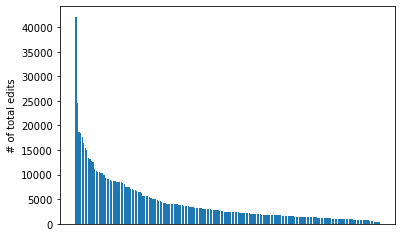

In [45]:
revs_counts = p_articles_revisions.groupby('page_title')['rev_timestamp'].agg(['count']).sort_values(by='count', ascending=False)
plt.bar(revs_counts.index, revs_counts["count"]);
plt.xticks([]);
plt.ylabel("# of total edits");

In [42]:
revs_counts.sample(n=10)

,count
page_title,
Psychologist,2091
Alzheimer's_disease,8317
Human_nutrition,1395
Dissociative_identity_disorder,6583
Mental_disorder,4840
Stuttering,2589
Drug_overdose,988
Emotion,4325
Value_(ethics),372


It seems that there are a lot of articles not related to mental health and well-being. In fact, *well-being* is among the last of all articles here. Let's select some of the articles related to mental health and plot edit statistics for them.

In [18]:
titles = ["Anxiety","Panic_disorder",
            "Personality_disorder",
            "Culture",
            "Suicide",
            "Maternal_health",
            "Denialism",
            "Value_(ethics)",
            "Social_determinants_of_health",
            "Loneliness",
            "Environmental_health",
            "Substance_abuse",
            "Epidemiology",
            "Insomnia",
            "Mental_disorder"]
years = [2018, 2019, 2020]

In [19]:
def small_multiples(t):
    revs = revisions[(revisions.page_title == t) & (revisions.rev_timestamp.dt.year.isin(years))]
    revs["ym"] = [datetime(year=y, month=m, day=1) for y,m in zip(revs.rev_timestamp.dt.year, revs.rev_timestamp.dt.month)]
    gb = revs.groupby([revs.ym])['page_title'].agg(['count'])
    
    return gb.index, gb["count"]

In order to detect significant changes in edit counts during first wave, let's point out Feb and Aug 2020.

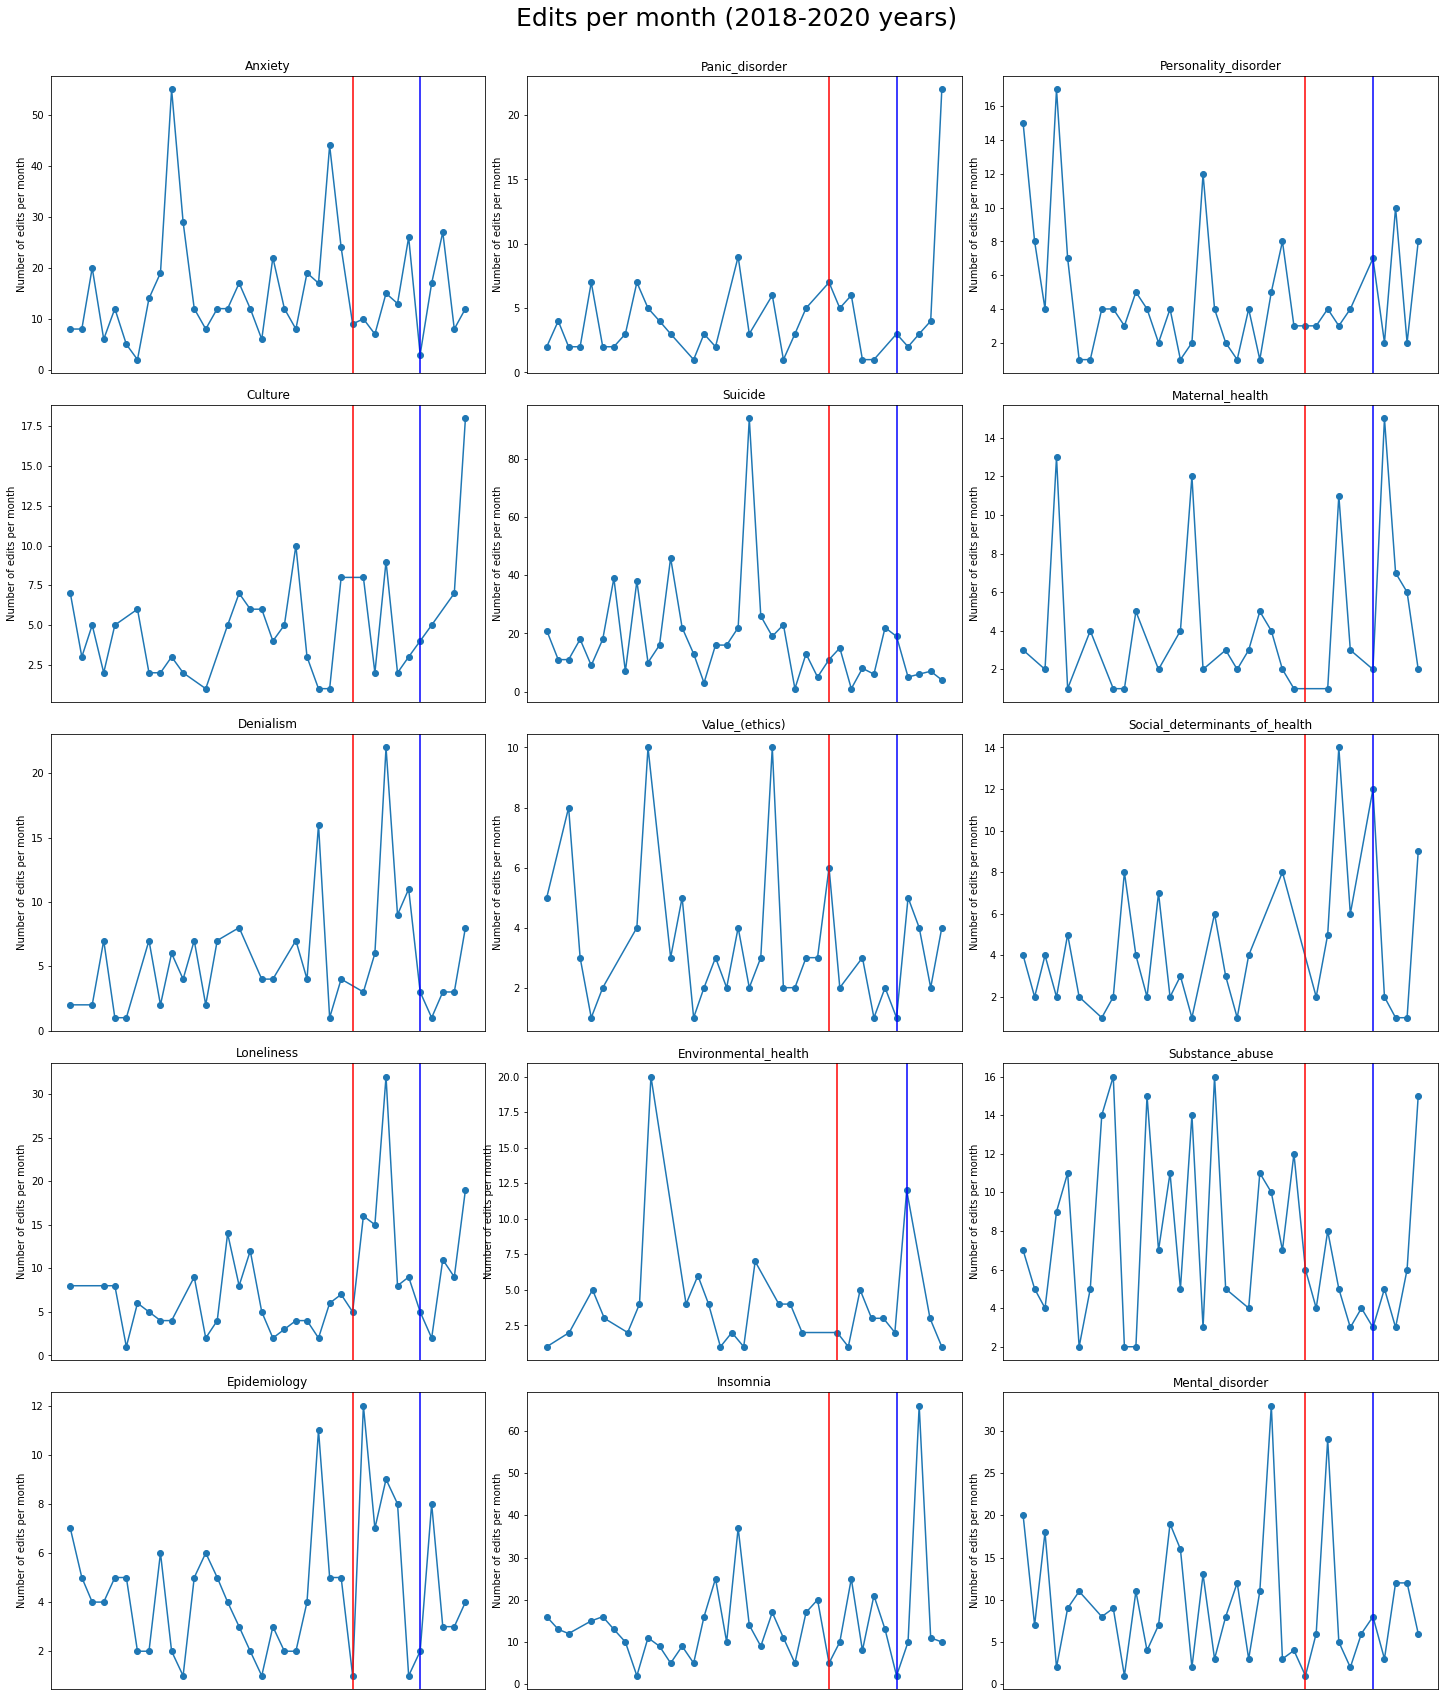

In [26]:
fig, axs = plt.subplots(5, 3, figsize=(20, 25))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for ax, t in zip(axs.ravel(), titles):
    x, y = small_multiples(t)
    ax.plot_date(x, y, linestyle='solid')
    ax.set_xticks([])
    ax.axvline(datetime(2020, 2, 1), color="red", label="feb 2020")
    ax.axvline(datetime(2020, 8, 1), color="blue", label="aug 2020")
    ax.set_title(t)
    ax.set_ylabel("Number of edits per month")
plt.suptitle("Edits per month (2018-2020 years)", fontsize=25);

### Preliminary conclusion
1. Regarding counts of edits, it seems that the amount of edits per month is relatively slow (less than 50), hence further analysis of the contributor diversity seems to be useless.
2. There is definitely should be some change in the articles sampling processing, because current set of articles have many articles outside of our interest.
3. Since temporal pageviews are more difficult to extract, I think we should improve #2 first.